In [1]:
from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

jax.config.update("jax_enable_x64", True)

## Reading and Displaying Fits File

In [2]:
def process_image(image, scale_factor=1, offset=1):
    scaled_image = (image[::scale_factor, ::scale_factor])[1::, 1::]
    cropped_image = image[70:210, 70:210]
    def safe_float32_conversion(value):
        try:
            return np.float32(value)
        except (ValueError, TypeError):
            print("This value is unjaxable: " + str(value))
    fin_image = np.nan_to_num(cropped_image)
    fin_image = np.vectorize(safe_float32_conversion)(fin_image)
    return fin_image

Filename: Fits/aumic_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     482   ()      
  1  SCI           1 ImageHDU       140   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


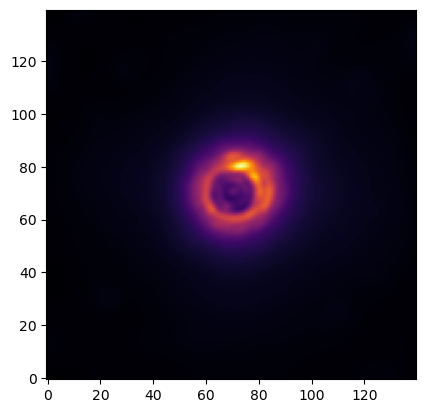

In [3]:
fits_image_filepath = "Fits/aumic_H_pol.fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
image = process_image(hdul['SCI'].data[0,:,:])

# Displays Image
plt.imshow(image, origin='lower', cmap='inferno')

## Displaying All Fits Files

In [4]:

fnames = os.listdir("Fits/")
print(fnames)

scale_factor = 1
images = []

for fname in fnames:
    hdul = fits.open("Fits/"+fname)
    image = process_image(hdul['SCI'].data[1,:,:])
    images.append(image)

['hd145560_H_pol.fits', 'hd146897_H_pol.fits', 'ceant_H_pol.fits', 'hd61005_H_pol.fits', 'hd111520_H_pol.fits', 'hd115600_H_pol.fits', 'hd129590_H_pol.fits', 'hd117214_H_pol.fits', 'betpic_H_pol.fits', 'hd35841_H_pol.fits', 'hd30447_H_pol.fits', 'hr7012_H_pol.fits', 'hd32297_H_pol.fits', 'hd110058_H_pol.fits', 'hd111161_H_pol.fits', 'hd157587_H_pol.fits', 'hr4796a_H_pol.fits', 'aumic_H_pol.fits', 'hd143675_H_pol.fits', 'hd131835_H_pol.fits', 'hd106906_H_pol.fits', 'hd114082_H_pol.fits', 'hd191089_H_pol.fits', 'hd156623_H_pol.fits']


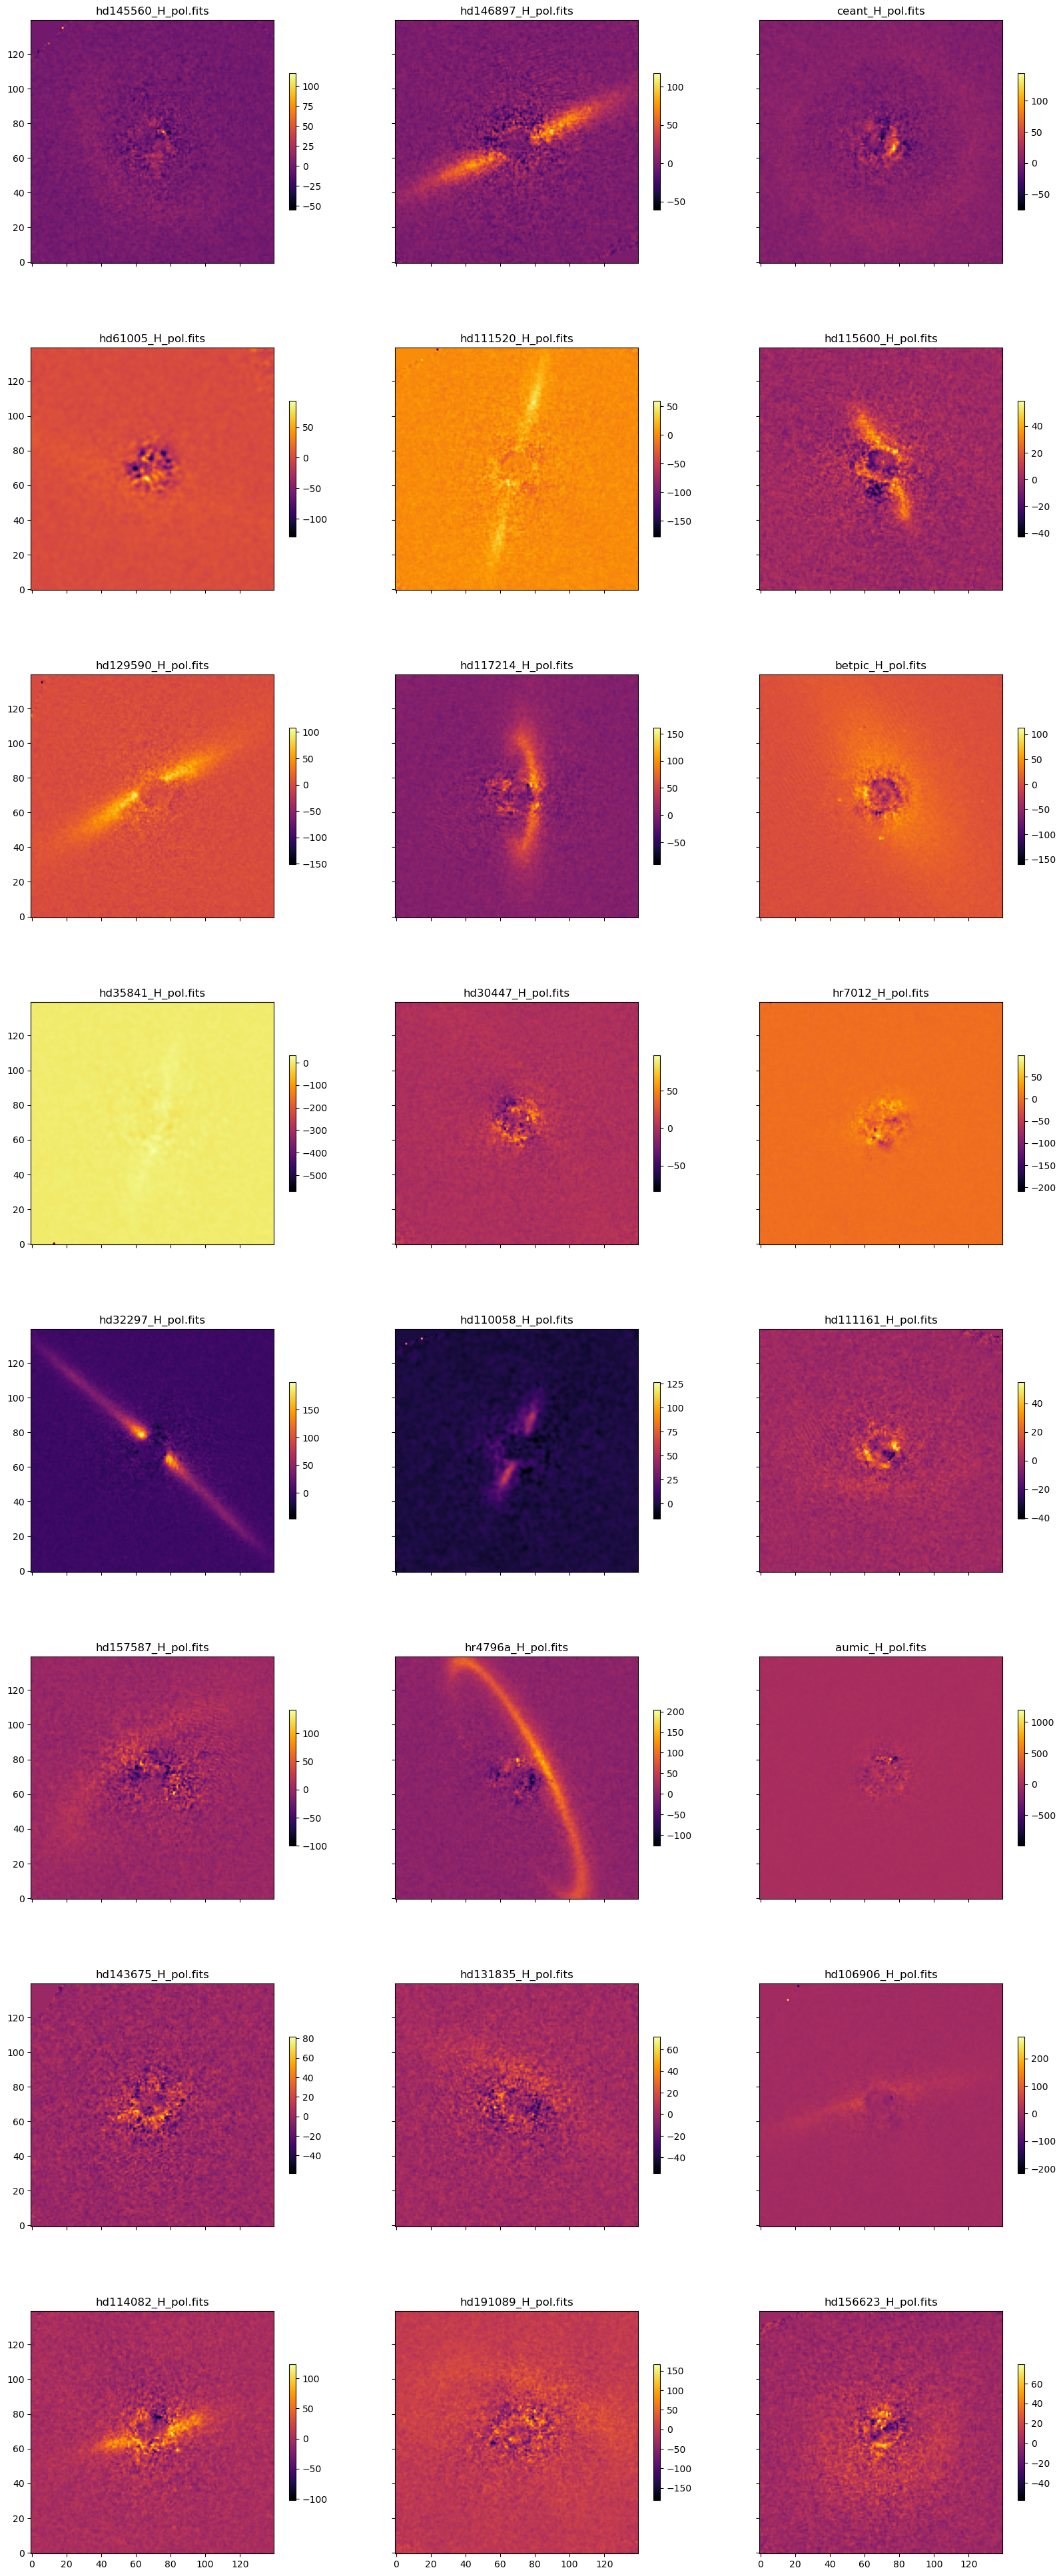

In [5]:
fig, axes = plt.subplots(8,3, sharex=True, sharey=True, figsize = (20,50))

for i in range(0, 8):
    for j in range(0, 3):
        im = axes[i][j].imshow(images[3*i+j], origin='lower', cmap='inferno')
        axes[i][j].set_title(fnames[3*i+j])
        plt.colorbar(im,ax=axes[i][j], shrink=0.5)

## Fitting Disk Models to Fits Images

In [6]:
from disk_utils_jax import jax_model_all_1d
from regression import log_likelihood_1d_pos_all_pars_spline
from scipy.optimize import minimize
from SLD_utils import *

In [7]:
# Creating error map
def create_circular_err_map(image_shape, iradius, oradius, noise_level):
    err_map = jnp.zeros(image_shape)
    center = image_shape[0]/2
    y, x = jnp.ogrid[:image_shape[0], :image_shape[1]]
    distance = jnp.sqrt((x - center) ** 2 + (y - center) ** 2)  
    err_map = jnp.where(distance <= oradius, noise_level, 0)
    err_map = jnp.where(distance >= iradius, err_map, 0)
    return err_map

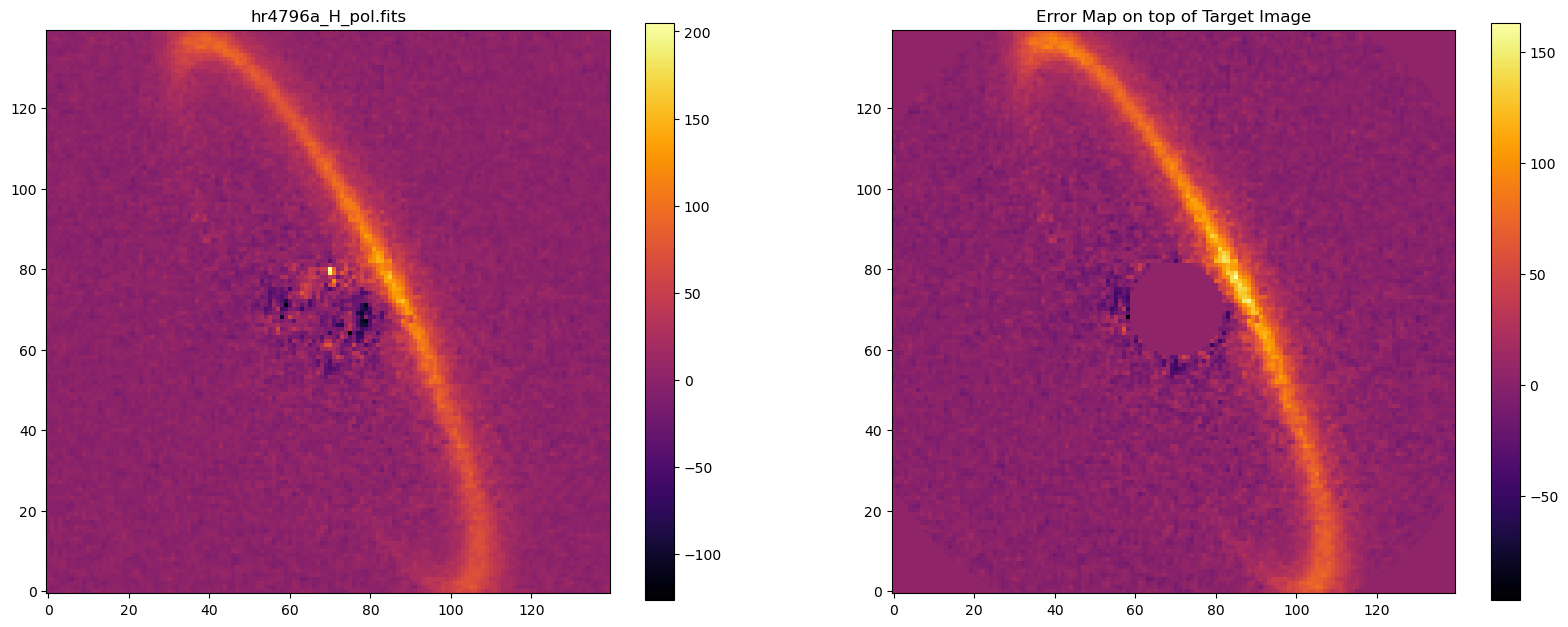

In [8]:
target_image = jnp.asarray(images[16])

fig, axes = plt.subplots(1, 2, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap = 'inferno')
axes[0].set_title(fnames[16])
plt.colorbar(im, ax=axes[0], shrink=0.75)

noise_level = 5
err_map = create_circular_err_map(target_image.shape, 12, 83, noise_level)
overlayed_image = jnp.where(err_map == 0, noise_level, target_image)
im = axes[1].imshow(overlayed_image, origin='lower', cmap = 'inferno')
axes[1].set_title("Error Map on top of Target Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

In [9]:

# Parameters
disk_params = {}
disk_params['inclination'] = 40. #In degrees
disk_params['position_angle'] = 50. #In Degrees
disk_params['alpha_in'] = 8. #The inner power law
disk_params['alpha_out'] = -5. #The outer power law
disk_params['flux_scaling'] = 1e6
disk_params['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

disk_params_1d = np.array([disk_params['alpha_in'], disk_params['alpha_out'], disk_params['sma'], disk_params['inclination'],
                           disk_params['position_angle']])
spline_params_1d= jnp.full(6, 0.05)   # random knot y-values
all_pars_spline = jnp.concatenate([disk_params_1d, spline_params_1d])

In [10]:
# Have to input spline parameters like this for the method to work
init_disk = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, all_pars_spline[0:5],
                                            InterpolatedUnivariateSpline_SPF.pack_pars(all_pars_spline[5:]), disk_params['flux_scaling'])

#plt.imshow(init_disk, origin='lower', cmap='inferno')
#plt.title("Initial Guess")

In [11]:
print(log_likelihood_1d_pos_all_pars_spline(all_pars_spline, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        disk_params['flux_scaling'], target_image, err_map))

1543769.1141094686


In [12]:
llp = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        disk_params['flux_scaling'], target_image, err_map, pxInArcsec=0.01414)

opt = {'disp':True,'maxiter':3000}
soln_spline = minimize(llp, all_pars_spline, options=opt, method = None)

print(soln_spline)

         Current function value: 48712.440168
         Iterations: 84
         Function evaluations: 1416
         Gradient evaluations: 118
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 48712.440168121095
        x: [ 1.702e+01 -9.989e+00  5.288e+01  7.719e+01  2.701e+01
             6.594e-02  2.398e-02  2.295e-02  1.327e-02  6.504e-03
            -3.132e-03]
      nit: 84
      jac: [ 0.000e+00  1.465e-03  9.766e-04 -2.441e-03  1.465e-03
             2.075e-01  3.042e-01 -4.102e-02 -2.598e-01  5.029e-02
             6.982e-02]
 hess_inv: [[ 2.222e-01  3.406e-02 ...  1.355e-05 -1.495e-05]
            [ 3.406e-02  6.628e-03 ...  1.067e-06 -1.957e-06]
            ...
            [ 1.355e-05  1.067e-06 ...  1.364e-08 -1.001e-08]
            [-1.495e-05 -1.957e-06 ... -1.001e-08  3.833e-08]]
     nfev: 1416
     njev: 118


/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [13]:
# Have to input spline parameters like this for the method to work
disk_image_fit_spline = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, soln_spline.x[0:5],
                                            InterpolatedUnivariateSpline_SPF.pack_pars(soln_spline.x[5:]), disk_params['flux_scaling'],
                                            pxInArcsec=0.01414)

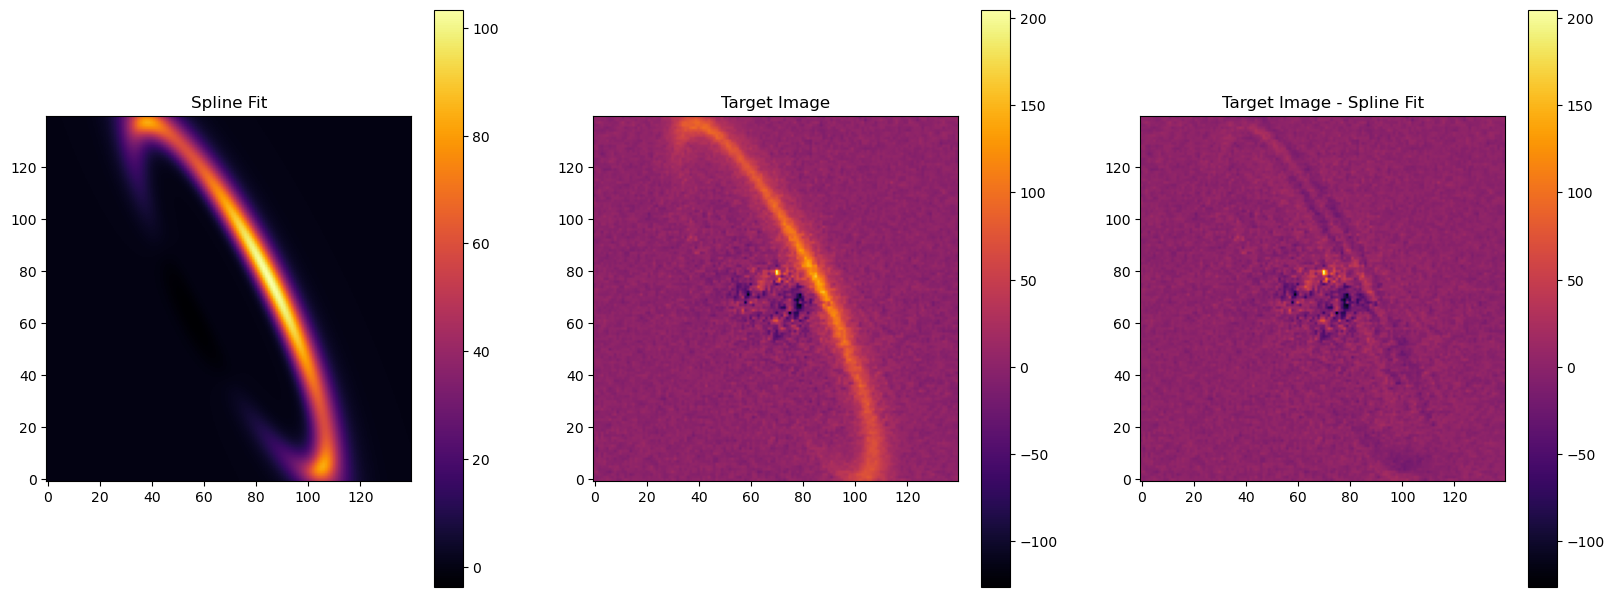

In [14]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(disk_image_fit_spline, origin='lower', cmap='inferno')
axes[0].set_title("Spline Fit")
plt.colorbar(im, ax=axes[0], shrink=0.75)

im = axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

im = axes[2].imshow(target_image-disk_image_fit_spline, origin='lower', cmap='inferno')
axes[2].set_title("Target Image - Spline Fit")
plt.colorbar(im, ax=axes[2], shrink=0.75)

In [15]:
print(log_likelihood_1d_pos_all_pars_spline(all_pars_spline, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        disk_params['flux_scaling'], target_image, err_map, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414))

642983973.3362823


In [16]:
from optimize import quick_optimize, quick_image

err_map = create_circular_err_map(target_image.shape, 12, 83, 5)
soln = quick_optimize(target_image, err_map, method = None, iters = 2000, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414)

disk_image_fit_spline = quick_image(soln, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414)

()
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 50922.82467272332
        x: [ 1.415e+01 -1.993e+01  5.448e+01  7.802e+01  2.717e+01
             4.375e-03  1.529e-03  1.366e-03  8.861e-04  4.030e-04
            -2.431e-04]
      nit: 151
      jac: [-1.465e-03  4.883e-04 -9.766e-04  1.953e-03  4.883e-04
             7.044e+00  1.321e+00 -8.240e+00  3.408e-01  7.020e+00
             5.655e+00]
 hess_inv: [[ 5.076e-02 -3.451e-02 ...  8.529e-07 -1.013e-06]
            [-3.451e-02  3.635e-02 ... -8.046e-07  7.767e-07]
            ...
            [ 8.529e-07 -8.046e-07 ...  6.815e-11 -5.808e-11]
            [-1.013e-06  7.767e-07 ... -5.808e-11  2.057e-10]]
     nfev: 2328
     njev: 194


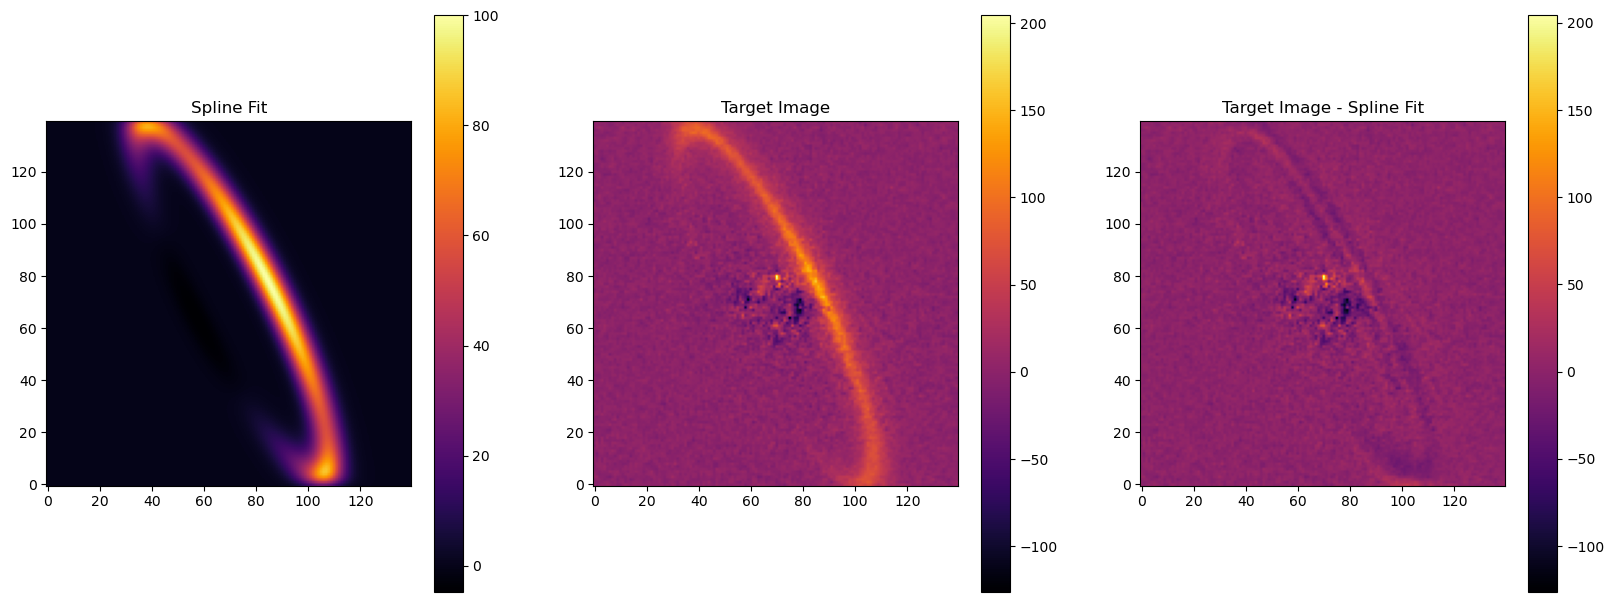

In [17]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(disk_image_fit_spline, origin='lower', cmap='inferno')
axes[0].set_title("Spline Fit")
plt.colorbar(im, ax=axes[0], shrink=0.75)

im = axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

im = axes[2].imshow(target_image - disk_image_fit_spline, origin='lower', cmap='inferno')
axes[2].set_title("Target Image - Spline Fit")
plt.colorbar(im, ax=axes[2], shrink=0.75)

## Shifting Image Center

In [18]:
@jax.jit
def shift_center(img, center, new_center=None, flipx=False, astr_hdr=None):
    #create the coordinate system of the image to manipulate for the transform
    dims = img.shape
    x, y = jnp.meshgrid(jnp.arange(dims[1], dtype=jnp.float32), jnp.arange(dims[0], dtype=jnp.float32))

    #if necessary, move coordinates to new center
    if new_center is not None:
        dx = new_center[0] - center[0]
        dy = new_center[1] - center[1]
        x -= dx
        y -= dy

    #flip x if needed to get East left of North
    if flipx is True:
        x = center[0] - (x - center[0])

    # resampled_img = jax_pyklip_nan_map_coordinates_2d(img, yp, xp)
    resampled_img = jax.scipy.ndimage.map_coordinates(jnp.copy(img), jnp.array([y, x]),order=1,cval = 0.)

    return resampled_img

In [19]:
ll = lambda x, y: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        disk_params['flux_scaling'], y, err_map, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414)

def likelihood_image_shift(pars):
    return ll(pars[2:], shift_center(target_image, (70,70), new_center=(pars[0], pars[1])))

all_pars_cent = jnp.concatenate([jnp.array([70, 70]), all_pars_spline])

min_pars = minimize(likelihood_image_shift, all_pars_cent)
print(min_pars)
cent_image = shift_center(quick_image(min_pars.x[2:], PSFModel=GAUSSIAN_PSF), (70,70), new_center=(min_pars.x[0], min_pars.x[1]))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 42327.78635350082
        x: [ 7.054e+01  6.950e+01 ...  3.647e-04 -2.224e-04]
      nit: 385
      jac: [ 8.353e+02 -2.733e+03 ... -1.857e+01  1.508e+00]
 hess_inv: [[ 1.331e-09 -2.419e-10 ... -7.467e-12 -7.306e-12]
            [-2.419e-10  4.669e-11 ...  3.027e-12  8.887e-14]
            ...
            [-7.467e-12  3.027e-12 ...  5.345e-11 -4.489e-11]
            [-7.306e-12  8.887e-14 ... -4.489e-11  1.371e-10]]
     nfev: 8923
     njev: 636


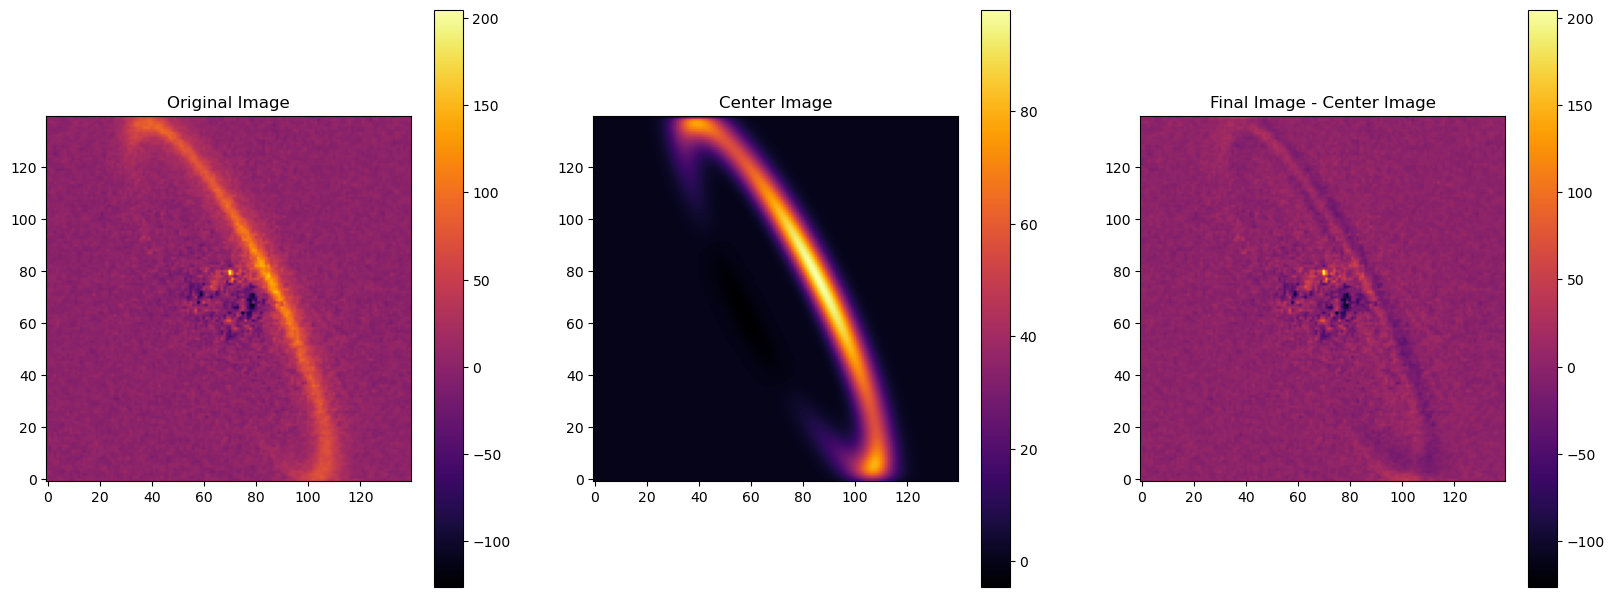

In [20]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)

im = axes[1].imshow(cent_image, origin='lower', cmap='inferno')
axes[1].set_title("Center Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

im = axes[2].imshow(target_image-cent_image, origin='lower', cmap='inferno')
axes[2].set_title("Final Image - Center Image")
plt.colorbar(im, ax=axes[2], shrink=0.75)